# Overview
## Objectives 

* What's bootstrap / shuffle test? 
* Why do we need bootstrap / shuffle test?
* Examples
    * Use shuffle test on image data
    * Use bootstrap / shuffle to extract confidence interval of parameter in visual tuning
* General procedure of bootstrap

![Cycle of Science](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/_images/cycle_of_science.png)

Credit to the [Caltech course BE BI103](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/index.html)

Casually speaking, bootstrapping is a way to test your hypothesis (just like t test or ANOVA), or estimate condifence interval of parameters, by randomizing your data. 

It works even when your data violates assumptions of parameteric tests (t ANOVA etc.)! (Detailed below.)

# An example of bootstrap using images

Imagine that you just collected images of two fluorescent reporters, on the same tissue section. 
(These might be two different fluorescently-labeled antibodies, or GFP vs RFP, etc.)

*Note, from the same sample is crucial! *

*Data courtesy of the Burkhalter lab. Code credit to Tim.*

In [312]:
from matplotlib import pyplot as plt
import numpy as np
import statistics
import scipy.stats
import skimage

In [313]:
imgr = skimage.io.imread("red.jpg")
imgg = skimage.io.imread("green.jpg")

(-0.5, 1391.5, 1039.5, -0.5)

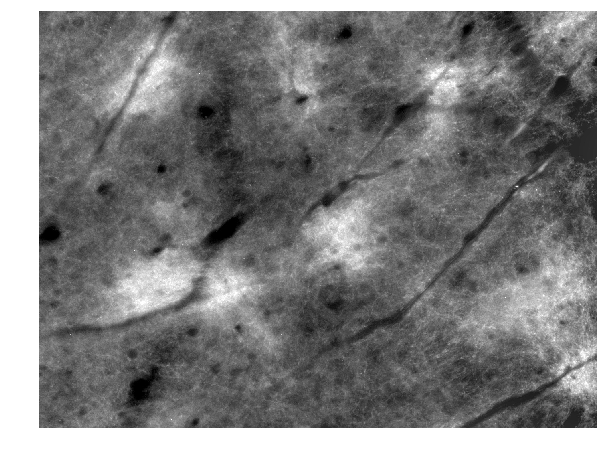

In [314]:
plt.figure(figsize=[10,8])
plt.imshow(imgr, cmap="gray")
plt.axis('off')

(-0.5, 1391.5, 1039.5, -0.5)

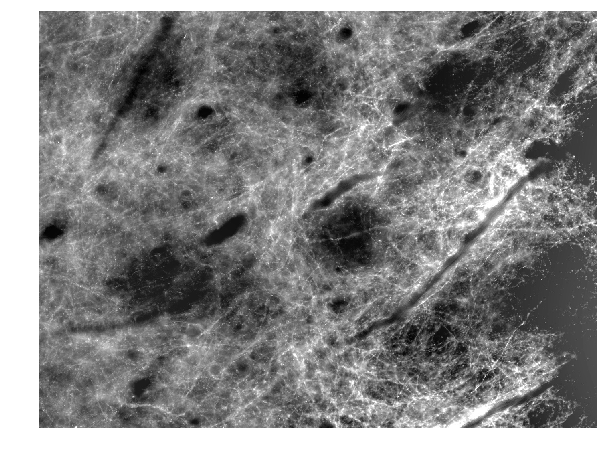

In [315]:
plt.figure(figsize=[10,8])
plt.imshow(imgg, cmap="gray")
plt.axis('off')

Are these images related? What's the relationship between them?

(-0.5, 1391.5, 1039.5, -0.5)

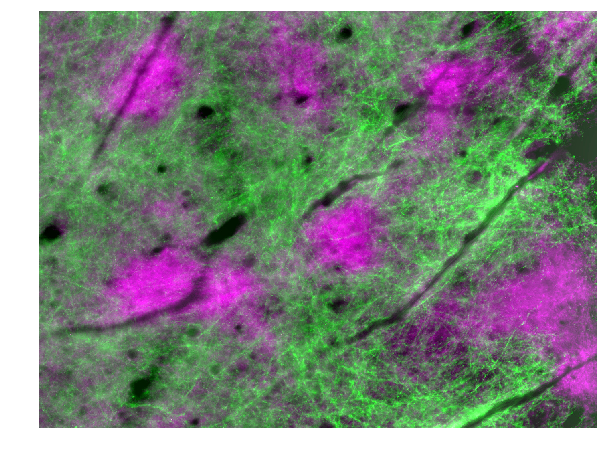

In [36]:
imgmerged = skimage.io.imread("merged.jpg")
plt.figure(figsize=[10,8])
plt.imshow(imgmerged)
plt.axis('off')

You observe that the magenta patches avoid the green regions, i.e. the bright patch in magenta and dark part in green of image match closely! 

**Working Hypothesis**: the magenta patches avoid the green regions

(-12.753696236559144,
 267.7536962365592,
 -12.753794150110373,
 267.75379415011037)

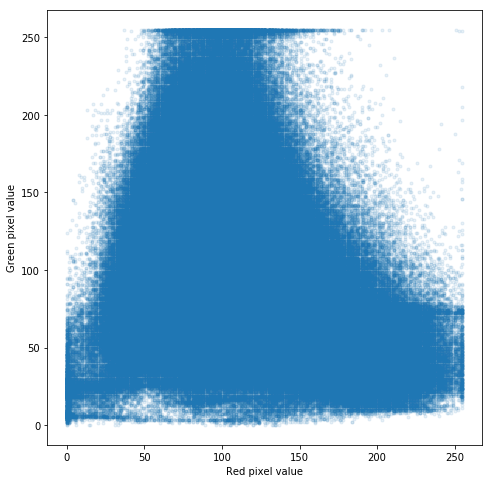

In [47]:
plt.figure(figsize=[8,8])
plt.scatter(imgr.flatten(), imgg.flatten(), marker='.', alpha =0.1)
plt.xlabel("Red pixel value")
plt.ylabel("Green pixel value")
plt.axis('image')

In [9]:
np.corrcoef(imgr.flatten(), imgg.flatten())

array([[ 1.        , -0.25098454],
       [-0.25098454,  1.        ]])

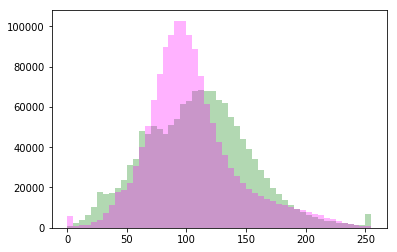

In [46]:
# Let's ask: do the high intensity pixels in imgr tend to have low intensity in imgg?
plt.hist(imgg.flatten(), bins=51, alpha=0.3, color='green');
plt.hist(imgr.flatten(), bins=51, alpha=0.3, color='magenta');

**Worth noting**: these are clearly not Gaussian distribution, 

* Green channel is bimodel
* Red channel has a long tail

We don't know what the distribution is.

In [49]:
thresh =  150   # anything higher than 150 we'll call "high intensity"

In [60]:
rhigh_msk = imgr > thresh

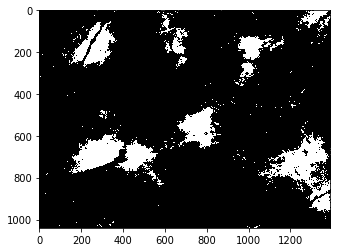

In [61]:
plt.imshow(rhigh_msk, cmap='gray')


Do the pixels that are high intensity in `imgr` have lower intensity in `imgg`?

In [317]:
imgg[rhigh_msk].astype('float').mean()

64.32392734741644

In [319]:
imgg[~rhigh_msk].astype('float').mean()

115.52739419995969

Can we test the significance? We could do a t-test:

In [321]:
len(imgg[~rhigh_msk])

1280198

In [64]:
scipy.stats.ttest_ind(imgg[rhigh_msk], imgg[~rhigh_msk])

Ttest_indResult(statistic=-484.3933399280594, pvalue=0.0)

Woohoo! This seems so significant, `ttest_ind` can't even measure the p-value! So it might seem like we're right.

**BUT**, If you submitted this in a manuscript, your reviewers would probably reject your paper. One (minor) reason is that the distribution of intensities isn't Gaussian. (There will turn out to be a much more important reason, but we'll get to that a little later.) Suppose we want to take this non-Gaussian distribution seriously.

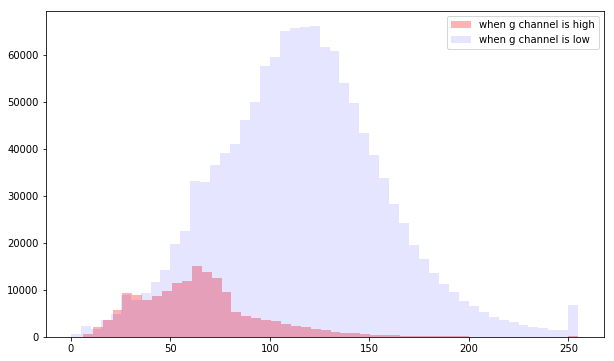

In [323]:
plt.figure(figsize=[10,6])
plt.hist(imgg[ishigh].flatten(), bins=51, alpha=0.3, color='red', label="when g channel is high");
plt.hist(imgg[~ishigh].flatten(), bins=51, alpha=0.1, color='blue', label="when g channel is low");
plt.legend();

## How can we do something like a t-test when we don't know the (form of) underlying distribution?

Remember that "hypothesis testing by simulation" can handle anything, *in principle*. But here *we don't know the underlying distribution of intensities*. So how do we simulate it? 

Recall your journey through homework 3, now you don't have your `flip_coin` function! 

The big idea: use **randomization** to *simulate* drawing from an underlying distribution. This is called the **bootstrap**. 
* The distribution can be your null, or your test distribution, depending on randomization method. 

In this case, you want to simulate distribution based on your null hypothesis. Your thought process: 

* For t-test, the **Null** is there is *no intensity difference* in green channel, where red channel is brigher (`rhigh_msk`) or everywhere else. 

* If null is right, draw pixel sample from anywhere in the green image `imgg` should be the same! 

* Thus I can sample my `red high` pixel collection from anywhere in the green image! Same for `red low`. Since they all have the same distribution. 
    * **Note** You effectively shuffle the pixel labels (`red high` and `red low`) across the whole image! 

In [324]:
# How many pixels in imgr are high? How many are not?
print(rhigh_msk.sum())
print((~rhigh_msk).sum())
rhigh_num = rhigh_msk.sum()
rlow_num = (~rhigh_msk).sum()

167482
1280198


In [334]:
np.random.choice([1, 0, 3, 6, 9], 3, replace=False,)

array([1, 6, 9])

In [336]:
# Randomly sample that number of pixels from `imgg` 
imggf = imgg.flatten()
fakehigh = np.random.choice(imggf, rhigh_num)
fakelow = np.random.choice(imggf, rlow_num)
print(statistics.mean(fakehigh.astype('float')))
print(statistics.mean(fakelow.astype('float')))

109.52042010484709
109.5877325226254


In [70]:
# Almost the same! Compare the difference across trials (Note: there's a performance problem here, I am surprised it is so slow)
meandiff = []
for i in range(100):
    fakehigh = np.random.choice(imggf, rhigh_num)
    fakelow = np.random.choice(imggf, rlow_num)
    meandiff.append(statistics.mean(fakehigh.astype('float')) - statistics.mean(fakelow.astype('float')))

KeyboardInterrupt: 

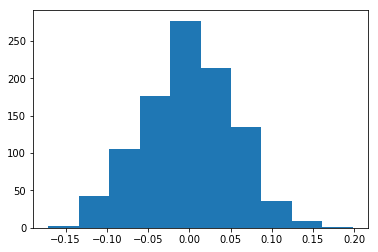

In [82]:
plt.hist(meandiff);

What's our statistics using the real red image?

In [81]:
imgg[rhigh_msk].astype('float').mean() - imgg[~rhigh_msk].astype('float').mean()

-51.203466852543244

This is so far in the tail of the distribution that we can't even measure the significance. So the non-Gaussian nature of the distribution is not a problem!

Actually, our initial observation is, the bright part of red image has a pretty good alignment with the dark part of green image. 

* What we want to test a **random mask** or a **random red image** (null) doesn't have this property! 
    * The meaning of random is crucial! 
* Literally we can generate some random masks and test our statistics (*difference of mean intensity within mask vs outside mask*)

In [98]:
%%time
meandiff = []
pixnum = imgr.size
for i in range(500):
    chosen_idx = np.random.choice(pixnum, size=rhigh_num,replace=False)  
    msk = np.zeros(pixnum).astype('bool')
    msk[chosen_idx] = True
    fake_rhigh = imgg.flatten()[chosen_idx]
    fake_rlow = imgg.flatten()[~msk]
    meandiff.append(fake_rhigh.astype('float').mean() - fake_rlow.astype('float').mean())

CPU times: user 38.2 s, sys: 1.62 s, total: 39.8 s
Wall time: 41.5 s


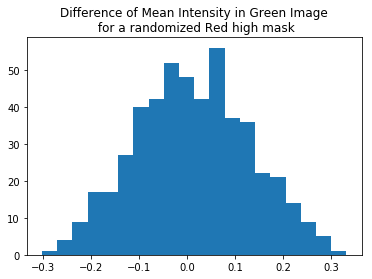

In [337]:
plt.hist(meandiff,bins=20);
plt.title("Difference of Mean Intensity in Green Image\n for a randomized Red high mask");

However, this test fails to capture a crucial point: *pixels are not independent*. Specifically, pixels seem related to their neighbors. Here's what a *scrambled* image looks like:

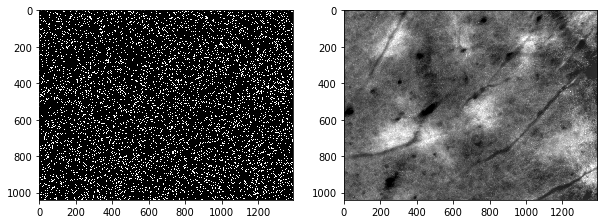

In [338]:
chosen_idx = np.random.choice(pixnum, size=rhigh_num,replace=False) 
msk = np.zeros(pixnum).astype('float32')
msk[chosen_idx] = 1.0
imgscramb = msk.reshape(imgg.shape)
plt.figure(figsize=[10,6])
plt.subplot(121)
plt.imshow(imgscramb, cmap='gray');
plt.subplot(122)
plt.imshow(imgr, cmap='gray')

That looks *nothing* like the images or masks we acquired. So randomizing pixels is not a very realistic model of the "a random mask" in our null hypothesis. 
* *It is random in some sense, but not in the sense we are testing!*

The serious fear is that maybe we just got lucky that ~7 blobs ended up inside ~7 holes. This is why a perceptive reviewer would skewer your paper.

How can we address this?

## Generating a more realistic null hypothesis

If the hypothesis is that the two images are aligned in some way, you can preserve the structure of individual images but randomize their *alignment*. In other words, we "scramble" the alignment but not the pixels.

### Shifting images

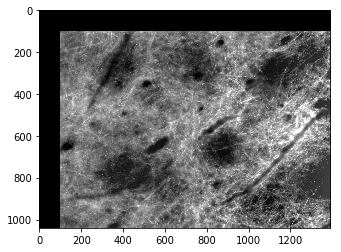

In [49]:
imggshift = np.zeros(imgg.shape, imgg.dtype)
imggshift[100:,100:] = imgg[0:-100,0:-100]
plt.imshow(imggshift, cmap='gray') 

In [136]:
# A function to do more version of it
def roll_image(img, yroll, xroll):
    imggxshift = np.zeros(img.shape, img.dtype)
    imggyshift = np.zeros(img.shape, img.dtype)
    #assert xroll * yroll is not 0
    if xroll is not 0:
        imggxshift[xroll:,:] = img[:-xroll,:]
        imggxshift[:xroll,:] = img[-xroll:,:] # roll the lower edge up to fill the blank!
    else:
        imggxshift = img.copy()
    if yroll is not 0:
        imggyshift[:,yroll:] = imggxshift[:,:-yroll] # same for x axis.
        imggyshift[:,:yroll] = imggxshift[:,-yroll:]
    else:
        imggyshift = imggxshift
    return imggyshift

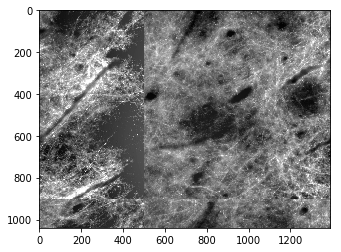

In [342]:
plt.imshow(roll_image(imgg, 500, 900), cmap='gray')

**Note**: The total number of bright pixel and the image pattern doesn't change ! So we are still randomly generating a mask, but this time keep far more structure in the data. 

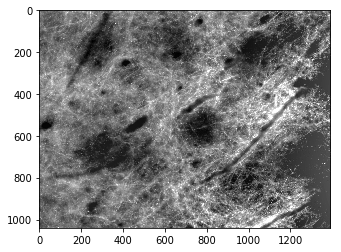

In [143]:
plt.imshow(imgg, cmap='gray')

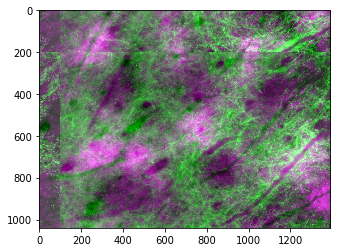

In [348]:
imggshift = roll_image(imgg, 100, 200)
imgo = np.zeros(imgmerged.shape, imgmerged.dtype)
imgo[:,:,0] = imgo[:,:,2] = imgr # magenta = Red + Blue Channel
imgo[:,:,1] = imggshift # green = Green Channel
plt.imshow(imgo)
# White = R + G + B

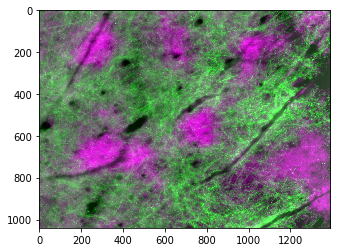

In [55]:
# Compare the original alignment
plt.imshow(imgmerged)

There's more white (= green + magenta = overlap) in the first image! It suggests that mess up with position will miss the alignment. 

What if we try our "brightness test"? (Different of mean intensity within and outside mask. )

In [147]:
imgg[rhigh_msk].astype('float').mean() - imgg[~rhigh_msk].astype('float').mean()   # bright parts in red channel are dim in green

-51.203466852543244

In [343]:
imggshift[rhigh_msk].astype('float').mean() - imggshift[~rhigh_msk].astype('float').mean()  # is this true if we translate the images?

17.868351269534514

Sure enough, with this shift there's even greater brightness in the green channel in places where red is high.

If we want to get the distribution for this null hypothesis, we need more shifts:

In [344]:
%%time
deltadiff = []
for i in range(1000):
    dx = np.random.randint(0, 700)       # cheating a bit to make this easy, really we should shift + and -
    dy = np.random.randint(0, 500)
    imggshift = roll_image(imgg, dx, dy)
    deltadiff.append(imggshift[rhigh_msk].astype('float').mean() - imggshift[~rhigh_msk].astype('float').mean())

CPU times: user 8.96 s, sys: 1.2 s, total: 10.2 s
Wall time: 12.2 s


-51.203466852543244


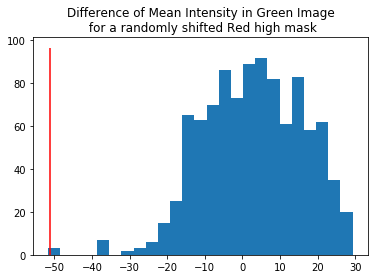

In [345]:
realdiff = imgg[rhigh_msk].astype('float').mean() - imgg[~rhigh_msk].astype('float').mean()   # bright parts in red channel are dim in green
print(realdiff)
plt.hist(deltadiff, bins=25);
plt.vlines(realdiff, plt.ylim()[0], plt.ylim()[1], color='r');
plt.title("Difference of Mean Intensity in Green Image\n for a randomly shifted Red high mask");

So again, we're very clearly outside the distribution, but by a much smaller z-score than before. (Much larger variability in the "null" distribution if we randomize this way). 

The reviewer was right to be worried, but in the end the result still held up. 

Why the variance is larger for the translation version?

## What's the general lesson?

* You can randomize your data to get a null distribution! You get bootstrapped. 
* Think about the meaning of "randomness". 
* You want a randomized but "reasonable" version of your data as *null*. 

* For images, you may want to keep the appearance similar, keep the local patches similar, color distribution etc. 
    * Translation, Rotation, Flipping ; Patch shuffling, etc. 
* For spike train, you may want to keep the over all firing rate, firing rate in a window, ISI distribution etc. the same.  
    * Spike time jittering; Spike clip shuffling etc. 
* Note the image and spike train share many similarities, they all have structure locally and globally. How you shuffle it depends on your hypothesis in mind. 

# Bootstrapping and Shuffle Test


Bootstrapping and Shuffle Test could be used to tackle 2 family of problems

* Compute **significance level** (p) when rejecting null hypothesis.
* Compute **confidence interval** (CI) when estimating parameter.

## Confidence Interval vs Significance Level (Recap)

* Confidence interval and Signifiance both represent some "robustness" of conclusion. 

* Confidence Inverval applies to **parameter estimation** scenario, 
    * Cf. Homework 3, given a set of coin flipping results $X=[0,1,0,0,1,1,1,1,1,1]$, how can I know the bias $b$ of underlying coin?
    * What are the possible **biases** that can generate this data ? (Confidence Interval)
* "I estimate some underlying parameter $b$ from data $X$ (through model fitting), can I give a range of parameter that are all possible?" 

* Significance Level applies to **hypothesis testing** scenario 
    * Cf. Homework 3, given a set of coin flipping results $X=[0,1,0,0,1,1,1,1,1,1]$, the p value of this result if the coin is fair? 
    * p value is the probability of getting this number of heads (7) or more imblanced heads. 
* "How (un)likely that my data (or more extreme data) is geneated by the world, if it conform to an uninteresting (null) hypothesis? (like $b=0.5$)"

* The CI and significance are answering the same question in different manner!
* Same message: 
    * Cf. Homework 3
    * If the 95% confidence interval estimation of bias (from $X$) is $b\in[.55,.65]$, then claiming "coin isn't fair" have less than 5% chance to be wrong. 
    * A fair coin have less than 5% chance of generating your data $X$, then claiming "coin isn't fair" is also justified.

* Different ways:
    * Confidence interval uses a inverse thinking: *infer the world through observation*
    * Significance level uses a forward thinking: *what are the potential outcomes, assuming the world is like null hypothesis*

## Why we use bootstrap?

* We already have t-test and ANOVA. 
* Both assume a Gaussian random variable model when generating your null distribution. 

* So we know the expected value ($t=0$ or $F=1$) and variability ($t-distribution, F-distribution$ ), for statistics!
* So compute significance and CI are easy

* *What if we don't know what to expect under null hypothesis?*
* *What if we don't know the distribution of some statistics (e.g. placeness score for a neuron)?*
( * *What if we cannot easily find a generative model for data (e.g. our `coin_flip` function)?*
    * So we cannot do millions of simulations like in Homework 3....)

* Experimentalist's approach is to do more exp, collect more data on control group and experiment group. (recall Homework 3, Q3)
* And then see the variability among control groups and exp groups. 
    * **But**, you don't want to re-run your control group thousands of time as well.

## So Bootstrapping come to rescue!

**Basic Philosophy of Bootstrap** is to 
* Randomize existing experimental data as a model of null distribution. (like $t$, or $F$ distribution. ) Then we can test the significance of experimental observation against this null. 
* A variant is to use existing data to simulate variability under realistic scenario, then we can estimate confidence interval of parameters. 

> *Bootstrapping*, comes from the saying "pick yourself up by pulling your bootstraps!* 
(Literally translated into *自助法* (*the method of helping yourself*) in Chinese)

> Here, in the sense of simulating statistical variability just from current data. 
![](https://i0.wp.com/statisticsbyjim.com/wp-content/uploads/2018/10/bootstrapping.png?resize=231%2C300&ssl=1)

**Bootstrap Procedure** for a statistics $\hat\theta$

* You get $n$ data points $X$ from experiments. You get one statistical estimate $\hat \theta(X)$
* Repeat $N$ times (like $1000000$):
    * Sample $n$ data with replacement from $X$, you get $X^{(i)}$
    * Compute your statistics on the resampled data $\hat \theta(X^{(i)})$
* Collect your resampled statistics, and plot the distribution $\{\hat \theta(X^{(1)}),\{\hat \theta(X^{(2)})....\}$
* Then you can estimate the variability of the statistics!

**Shuffle test** has a similar idea, 

* If you have some label for data (like condition for experiment, timing for spike, channel of recording), shuffling the labels can simulate your null! 
    * For spike time, it's a little tricky. Basically, jittering the spike time, or shuffling blocks of recording can work.

* The way of resmpling / shuffle is key! It should target your hypothesis.
* If you resample based on null hypothesis, then you are simulating the null hypothesis.  
    * e.g. Merging all the data from test group and control group

* If you resample based on working hypothesis / model, then you are simulating the working hypothesis
    * e.g. Resample data within each experiment condition.
    * e.g. If you hypothesize precise spike time won't affect your conclusion, jitter the spike time.
    * e.g. If you hypothesize cell identity won't affect your result, shuffle the identity. 

## Can you bootstrap the maximum value in a set?

## Can you bootstrap the 95% percentile from a 20 sample dataset?

### Cases when bootstrap can fail


* Too Small of a Sample Size
* Estimating Extreme Order Statistics (maximum, minimum)

* https://stats.stackexchange.com/questions/9664/what-are-examples-where-a-naive-bootstrap-fails
* [Bootstrap Methods: A Guide for Practitioners and Researchers](https://www.amazon.com/dp/0471756210/) Chap 9, "When Bootstrapping Fails Along with Some Remedies for Failures,"

# How Precise Can I Estimate Orientation Tuning Parameters?

We know some neurons in visual cortex fires in different rate towards different orientation of lines. 

![](https://med.libretexts.org/@api/deki/files/7191/fig_v1_orientation_tuning_data.jpg?revision=1&size=bestfit&width=550&height=468)

Some questions we may ask about the cell

* Is it tuned or not? How do we test 
* Can we describe this relationship more quantitatively with some parameters?
* How wide / sharp is the tuning?

>Are these cell tuned or not?

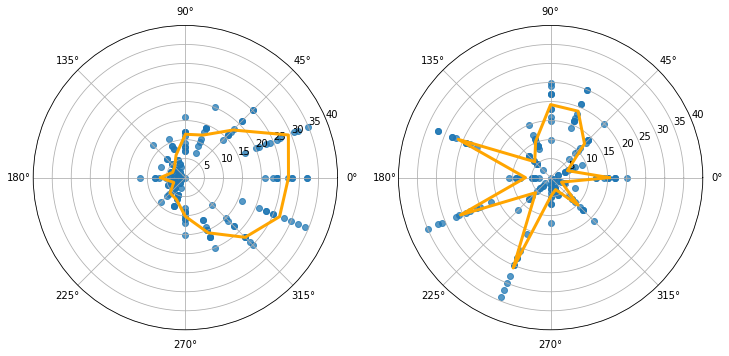

In [ ]:
shf_fr = shuffle_angle(fr_rsp)

plt.figure(figsize=[12,6])
ax = plt.subplot(121, polar=True)
c = plt.scatter(np.repeat(exp_theta[:,np.newaxis], trial_num, axis=1), fr_rsp, )#c=colors, s=area, cmap=cm.hsv
ax.set_ylim(0,40)
c.set_alpha(0.75)
mean_rsp = bstrp_fr.mean(axis=1)
idx = list(range(bin_num)) + [0] # use cyclic index to plot a circle.
ax.plot(exp_theta[idx], mean_rsp[idx], color="orange",lw=3)
#ax.set_title("Within condition shuffling")
ax = plt.subplot(122, polar=True)
c = plt.scatter(np.repeat(exp_theta[:,np.newaxis], trial_num, axis=1), shf_fr, )#c=colors, s=area, cmap=cm.hsv
ax.set_ylim(0,40)
c.set_alpha(0.75)
mean_rsp = shf_fr.mean(axis=1)
idx = list(range(bin_num)) + [0] # use cyclic index to plot a circle.
ax.plot(exp_theta[idx], mean_rsp[idx], color="orange",lw=3)
#ax.set_title("Angle shuffling")
plt.show()

**Recall** Larry's ANOVA lecture, ANOVA doesn't care sequence of label. So shuffle exp condition (angle) will not affect ANOVA statistics

* Here we are testing a stronger hypothesis than ANOVA! 
* We are testing the neuron's firing rate has some central tendency in the circular sense! (similar to mean, var) This will be changed if we mess up with the label $\theta$. 

**Circular statistics of mean (central tendency) and variance (spread)**: 

* Angle
* Normalized vector length

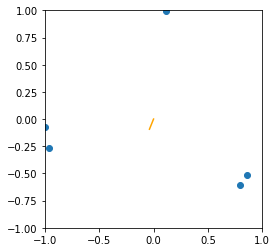

In [354]:
randang = 2*np.pi*np.random.rand(5)
xcoor = np.cos(randang)
ycoor = np.sin(randang)
plt.scatter(xcoor, ycoor)
plt.plot([0,xcoor.mean()],[0,ycoor.mean()],color='orange')
plt.axis('image')
plt.xlim([-1,1]);
plt.ylim([-1,1]);

## Let's load up a Dataset

In [355]:
import pickle
(exp_theta, fr_rsp) = pickle.load(open('V1fr_rsp.p',"rb"))

In [356]:
import pandas as pd

In [357]:
ang_in_deg =  exp_theta/np.pi *180
pd.DataFrame(fr_rsp, index=ang_in_deg)

,0,1,2,3,4,5,6,7,8,9
0.0,21,28,32,27,23,24,24,24,28,32
22.5,23,35,20,24,27,17,32,21,31,26
45.0,18,16,21,21,14,16,17,25,25,16
67.5,11,9,10,20,14,14,7,14,13,14
90.0,16,8,7,12,8,7,12,12,9,11
112.5,9,5,9,8,11,5,4,8,3,4
135.0,5,5,3,7,3,2,4,7,2,12
157.5,4,7,2,1,4,4,4,3,2,0
180.0,8,3,2,5,7,4,8,3,12,4
202.5,4,2,4,5,3,3,1,5,4,3


In [186]:
bin_num = len(exp_theta)
trial_num = fr_rsp.shape[1]

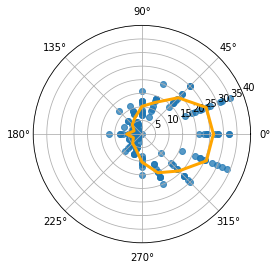

In [358]:
plt.figure()
ax = plt.subplot(111, polar=True)
c = plt.scatter(np.repeat(exp_theta[:,np.newaxis], trial_num, axis=1), fr_rsp, )#c=colors, s=area, cmap=cm.hsv
ax.set_ylim(0,40)
c.set_alpha(0.75)
mean_rsp = fr_rsp.mean(axis=1)
idx = list(range(bin_num)) + [0] # use cyclic index to plot a circle.
ax.plot(exp_theta[idx], mean_rsp[idx], color="orange",lw=3)
plt.show()

In [167]:
np.repeat(exp_theta[:,np.newaxis], trial_num, axis=1)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.39269908, 0.39269908, 0.39269908, 0.39269908, 0.39269908,
        0.39269908, 0.39269908, 0.39269908, 0.39269908, 0.39269908],
       [0.78539816, 0.78539816, 0.78539816, 0.78539816, 0.78539816,
        0.78539816, 0.78539816, 0.78539816, 0.78539816, 0.78539816],
       [1.17809725, 1.17809725, 1.17809725, 1.17809725, 1.17809725,
        1.17809725, 1.17809725, 1.17809725, 1.17809725, 1.17809725],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
        1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
       [1.96349541, 1.96349541, 1.96349541, 1.96349541, 1.96349541,
        1.96349541, 1.96349541, 1.96349541, 1.96349541, 1.96349541],
       [2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449,
        2.35619449, 2.35619449, 2.35619449, 2.35619449, 2.35619449],
       [2.74889357, 2.74889357, 2.7488935

In [359]:
mean_rsp

array([26.3, 25.6, 18.9, 12.6, 10.2,  6.6,  5. ,  3.1,  5.6,  3.4,  4.8,
        5.9, 10.3, 15.4, 19.2, 25.7])

## Is the Cell Tuned?

How should we test if the cell is circularly tuned?

In [360]:
mean_rsp = fr_rsp.mean(axis=1)
xcoor = np.cos(exp_theta[np.newaxis,:])*mean_rsp
ycoor = np.sin(exp_theta[np.newaxis,:])*mean_rsp
meanVec = np.array([xcoor.mean(), ycoor.mean()])

In [361]:
meanVec

array([ 5.50203239, -0.14149569])

In [221]:
def circ_mean(exp_theta, fr_rsp):
    mean_rsp = fr_rsp.mean(axis=1)
    xcoor = np.cos(exp_theta[np.newaxis,:])*mean_rsp
    ycoor = np.sin(exp_theta[np.newaxis,:])*mean_rsp
    mVec = np.array([xcoor.mean(), ycoor.mean()])
    return mVec
def circ_mean_polar(exp_theta, fr_rsp):
    mVec = circ_mean(exp_theta, fr_rsp)
    r = np.sqrt(mVec[0]**2 + mVec[1]**2)
    theta = np.arctan2(mVec[1], mVec[0])
    return r,theta

In [362]:
def shuffle_angle(fr_rsp):
    ang_n = fr_rsp.shape[0]
    perm_ang_idx = np.random.permutation(ang_n)
    return np.array(fr_rsp[perm_ang_idx, :])

In [366]:
pd.DataFrame(shuffle_angle(fr_rsp), index=ang_in_deg)

,0,1,2,3,4,5,6,7,8,9
0.0,5,5,3,7,3,2,4,7,2,12
22.5,23,35,20,24,27,17,32,21,31,26
45.0,21,25,28,16,25,34,23,30,23,32
67.5,16,8,7,12,8,7,12,12,9,11
90.0,4,2,4,5,3,3,1,5,4,3
112.5,8,3,2,5,7,4,8,3,12,4
135.0,9,4,4,7,6,5,5,4,2,2
157.5,9,5,9,8,11,5,4,8,3,4
180.0,21,28,32,27,23,24,24,24,28,32
202.5,18,16,21,21,14,16,17,25,25,16


In [367]:
%%time
rsmp_n = 10000
mVec_shf_col = []
Th_shf_col = []
for rsmp_i in range(rsmp_n):
    shuff_fr = shuffle_angle(fr_rsp)
    Vr, th = circ_mean_polar(exp_theta, shuff_fr)
    mVec_shf_col.append(Vr)
    Th_shf_col.append(th)
mVec_shf_col = np.array(mVec_shf_col)
Th_shf_col = np.array(Th_shf_col)

CPU times: user 1.18 s, sys: 33.5 ms, total: 1.22 s
Wall time: 1.75 s


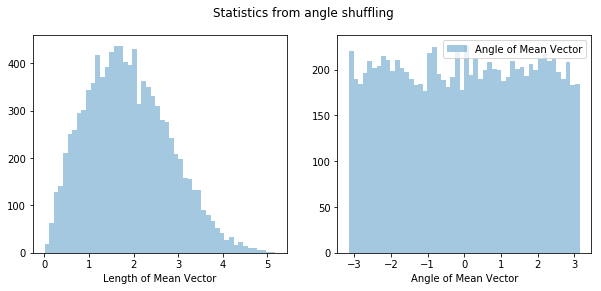

In [368]:
plt.figure(figsize=[10,4])
plt.subplot(121)
plt.hist(mVec_shf_col,bins=50,label="Length of Mean Vector",alpha=0.4)
plt.xlabel("Length of Mean Vector")
plt.subplot(122)
plt.hist(Th_shf_col,bins=50,label="Angle of Mean Vector",alpha=0.4)
plt.xlabel("Angle of Mean Vector")
plt.suptitle("Statistics from angle shuffling")
# plt.xlabel("\kappa")
plt.legend()
plt.show()

Now we can compute our p threshold from this

In [369]:
print("0.05 p threshold for Length of mean [%.3f,%.3f]"%(np.percentile(mVec_shf_col,2.5), np.percentile(mVec_shf_col,97.5)))
print("0.05 p threshold (one sided) for Length of mean %.3f"%(np.percentile(mVec_shf_col,95)))

0.05 p threshold for Length of mean [0.354,3.813]
0.05 p threshold (one sided) for Length of mean 3.505


## What if we use other methods to bootstrap it?

Just like image and spike train, here there are multiple ways we can do shuffling. 

* Trials number doesn't matter, so we can resample trials within each condition. 
    * This can introduce variability but not affect the result. 
* We can shuffle the whole matrix (trial and angle), instead of only shuffling rows. 
    * Compare to angle shuffling, now you break the structure (mean and var) within each experiment condition (angle).
    * This is also a simulation of `null` but a weaker one. 

In [370]:
def resample_all(fr_rsp):
    return np.random.choice(fr_rsp.reshape(-1), size=fr_rsp.shape, replace=True)
    
def resample_trials(fr_rsp):
    new_trials = []
    for i in range(fr_rsp.shape[0]):
        frs = np.random.choice(fr_rsp[i, :], size=fr_rsp.shape[1], replace=True)
        new_trials.append(frs)
    return np.array(new_trials)

def shuffle_angle(fr_rsp):
    ang_n = fr_rsp.shape[0]
    perm_ang_idx = np.random.permutation(ang_n)
    return np.array(fr_rsp[perm_ang_idx, :])

In [374]:
pd.DataFrame(resample_trials(fr_rsp), index=ang_in_deg) # data frame 

,0,1,2,3,4,5,6,7,8,9
0.0,32,32,23,24,24,23,24,23,28,24
22.5,23,17,21,23,23,27,26,17,20,26
45.0,21,18,21,16,16,21,16,17,16,21
67.5,14,20,10,14,20,7,7,9,14,11
90.0,16,16,8,12,16,7,8,8,12,11
112.5,8,8,5,4,4,8,9,5,8,5
135.0,4,3,2,3,3,7,7,4,5,3
157.5,1,4,1,1,0,0,3,4,2,1
180.0,5,12,3,7,2,3,3,12,2,8
202.5,4,5,4,1,1,2,3,2,3,4


In [376]:
pd.DataFrame(resample_all(fr_rsp), index=ang_in_deg)

,0,1,2,3,4,5,6,7,8,9
0.0,3,4,32,13,17,5,2,23,0,16
22.5,14,4,6,15,22,21,7,28,7,21
45.0,31,7,4,28,24,7,25,8,14,9
67.5,12,4,35,12,9,3,5,8,14,8
90.0,2,12,4,27,21,5,8,5,9,2
112.5,22,11,30,21,28,9,4,11,23,4
135.0,12,15,28,17,4,16,4,8,25,3
157.5,4,24,8,5,11,5,16,24,23,27
180.0,17,22,9,3,26,28,16,4,13,0
202.5,9,21,20,6,7,4,17,23,4,6


In [228]:
%%time
rsmp_n = 10000
mVec_col = []
Th_col = []
mVec_shf_col = []
Th_shf_col = []
mVec_null_col = []
Th_null_col = []
for rsmp_i in range(rsmp_n):
    bstrp_fr = resample_trials(fr_rsp)
    shuff_fr = shuffle_angle(fr_rsp)
    bstrp_null_fr = resample_all(fr_rsp)
    Vr, th = circ_mean_polar(exp_theta, bstrp_fr)
    Vr_shf, th_shf = circ_mean_polar(exp_theta, shuff_fr)
    Vr_null, th_null = circ_mean_polar(exp_theta, bstrp_null_fr)
    mVec_col.append(Vr)
    mVec_shf_col.append(Vr_shf)
    mVec_null_col.append(Vr_null)
    Th_col.append(th)
    Th_shf_col.append(th_shf)
    Th_null_col.append(th_null)
mVec_shf_col = np.array(mVec_shf_col)
Th_shf_col = np.array(Th_shf_col)

mVec_col = np.array(mVec_col)
mVec_shf_col = np.array(mVec_shf_col)
mVec_null_col = np.array(mVec_null_col)
Th_col = np.array(Th_col)
Th_shf_col = np.array(Th_shf_col)
Th_null_col = np.array(Th_null_col)
# param_shf_col = np.array(param_shf_col)

CPU times: user 5.03 s, sys: 57.3 ms, total: 5.09 s
Wall time: 5.41 s


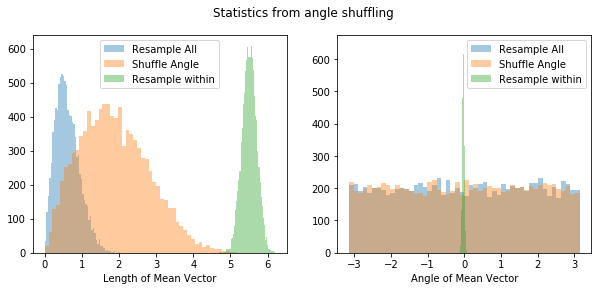

In [377]:
plt.figure(figsize=[10,4])
plt.subplot(121)
plt.hist(mVec_null_col,bins=50,label="Resample All",alpha=0.4)
plt.hist(mVec_shf_col,bins=50,label="Shuffle Angle",alpha=0.4)
plt.hist(mVec_col,bins=50,label="Resample within",alpha=0.4)
plt.xlabel("Length of Mean Vector")
plt.legend()
plt.subplot(122)
plt.hist(Th_null_col,bins=50,label="Resample All",alpha=0.4)
plt.hist(Th_shf_col,bins=50,label="Shuffle Angle",alpha=0.4)
plt.hist(Th_col,bins=50,label="Resample within",alpha=0.4)
plt.xlabel("Angle of Mean Vector")
plt.suptitle("Statistics from angle shuffling")
# plt.xlabel("\kappa")
plt.legend()
plt.show()

In [378]:
print("Length of mean vector 95%% CI [%.3f,%.3f]"%(np.percentile(mVec_col,2.5), np.percentile(mVec_col,97.5)))
print("Mean angle 95%% CI [%.3f,%.3f]"%(np.percentile(Th_col,2.5)/np.pi*180, np.percentile(Th_col,97.5)/np.pi*180))

Length of mean vector 95% CI [5.115,5.892]
Mean angle 95% CI [-4.694,1.825]


## Can we describe this relation with some parameter?

[Von Mises Tuning curve](https://en.wikipedia.org/wiki/Von_Mises_distribution), 
### $$f(\theta\mid\mu,\kappa)={A\over 2\pi I_0(\kappa)}\exp(\kappa \cos(x-\mu))$$

![PDF](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/VonMises_distribution_PDF.png/640px-VonMises_distribution_PDF.png)

In [163]:
def vonMises(theta, A=1, mu=0, kappa=1):
    return A * np.exp(kappa * np.cos(theta-mu))

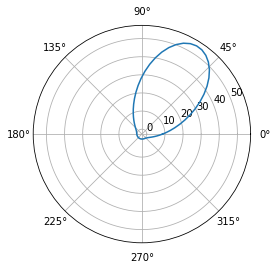

In [164]:
theta = np.linspace(0, 2*np.pi, 100, endpoint=True)
plt.polar(theta,vonMises(theta,mu=1,kappa=4))
plt.show()

Let's fit the data with curve fitting functions. 

In [211]:
from scipy.optimize import curve_fit

In [188]:
from scipy.optimize import curve_fit
def vonMises(theta, A=1, mu=0, kappa=1):
    return A * np.exp(kappa * np.cos(theta-mu))
def fit_vonMises(exp_theta, fr_rsp):
    trial_num = fr_rsp.shape[1]
    xdata = np.repeat(exp_theta[:,np.newaxis], trial_num, axis=1).reshape(-1)
    ydata = fr_rsp.reshape(-1)
    param, paramcov = curve_fit(vonMises, xdata, ydata, p0=[1,0,1])
    return param

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [213]:
xdata = np.repeat(exp_theta[:,np.newaxis], trial_num, axis=1).reshape(-1)
ydata = fr_rsp.reshape(-1)
curve_fit(vonMises, xdata, ydata, p0=[1,0,1])
#curve_fit(vonMises, exp_theta, mean_rsp, p0=[1,0,1])

(array([10.1599193 ,  0.01287282,  0.98418415]),
 array([[ 1.28300721e-01,  6.65156466e-09, -1.34915822e-02],
        [ 6.65156466e-09,  9.48800973e-04, -8.00568456e-12],
        [-1.34915822e-02, -8.00568456e-12,  1.91753997e-03]]))

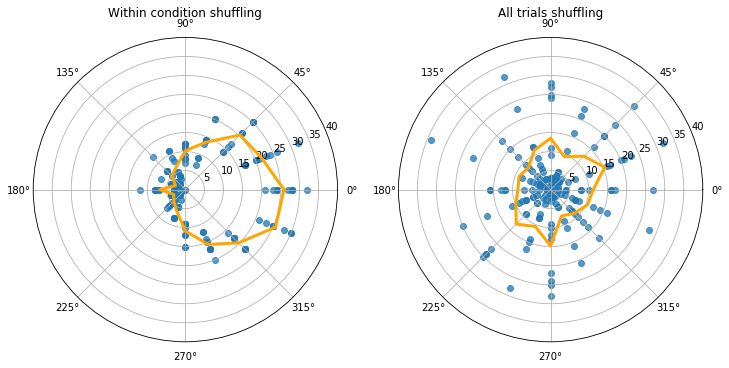

In [207]:
bstrp_fr = resample_trials(fr_rsp)
bstrp_null_fr = resample_all(fr_rsp)

plt.figure(figsize=[12,6])
ax = plt.subplot(121, polar=True)
c = plt.scatter(np.repeat(exp_theta[:,np.newaxis], trial_num, axis=1), bstrp_fr, )#c=colors, s=area, cmap=cm.hsv
ax.set_ylim(0,40)
c.set_alpha(0.75)
mean_rsp = bstrp_fr.mean(axis=1)
idx = list(range(bin_num)) + [0] # use cyclic index to plot a circle.
ax.plot(exp_theta[idx], mean_rsp[idx], color="orange",lw=3)
ax.set_title("Within condition shuffling")
ax = plt.subplot(122, polar=True)
c = plt.scatter(np.repeat(exp_theta[:,np.newaxis], trial_num, axis=1), bstrp_null_fr, )#c=colors, s=area, cmap=cm.hsv
ax.set_ylim(0,40)
c.set_alpha(0.75)
mean_rsp = bstrp_null_fr.mean(axis=1)
idx = list(range(bin_num)) + [0] # use cyclic index to plot a circle.
ax.plot(exp_theta[idx], mean_rsp[idx], color="orange",lw=3)
ax.set_title("All trials shuffling")
plt.show()

In [280]:
param = fit_vonMises(exp_theta, bstrp_fr)
param_null = fit_vonMises(exp_theta, bstrp_null_fr)

In [281]:
param

array([10.01060815, -0.05899186,  1.04582226])

In [282]:
param_null

array([12.25909383,  1.07320569,  0.27231751])

Let's do more fitting and find out the distribution.

In [198]:
%%time
rsmp_n = 10000
param_col = []
param_shf_col = []
param_null_col = []
for rsmp_i in range(rsmp_n):
    # fit_vonMises(exp_theta, bstrp_fr)
    bstrp_fr = resample_trials(fr_rsp)
    shuff_fr = shuffle_angle(fr_rsp)
    bstrp_null_fr = resample_all(fr_rsp)
    param = fit_vonMises(exp_theta, bstrp_fr)
    param_shf = fit_vonMises(exp_theta, shuff_fr)
    param_null = fit_vonMises(exp_theta, bstrp_null_fr)
    param_col.append(param)
    param_shf_col.append(param_shf)
    param_null_col.append(param_null)
param_col = np.array(param_col)
param_shf_col = np.array(param_shf_col)
param_null_col = np.array(param_null_col)

CPU times: user 38.6 s, sys: 445 ms, total: 39 s
Wall time: 42.5 s


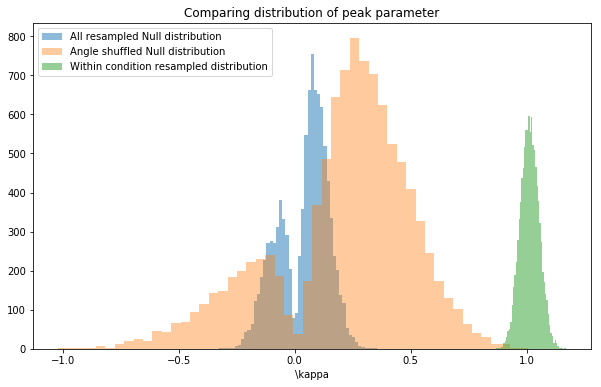

In [202]:
plt.figure(figsize=[10,6])
plt.hist(param_null_col[:,2],bins=50,label="All resampled Null distribution",alpha=0.5)
plt.hist(param_shf_col[:,2],bins=50,label="Angle shuffled Null distribution",alpha=0.4)
plt.hist(param_col[:,2],bins=50,label="Within condition resampled distribution",alpha=0.5)
plt.title("Comparing distribution of peak parameter")
plt.xlabel("\kappa")
plt.legend()
plt.show()

## General lessons
* The less you alter your data, the more statistical structure your bootstrapped data will share with your real data. 
* If you use it as your null, then the less you alter, the more challenging test you are using. 
* At one point, your bootstrapped data is "indistinguishable" from your experimental data. 
    * Then you know, the thing you randomize does not affect the property you are testing! Now you are simulating your experiment distibution.
* And you can see Bootstrap follows the same procedure, agnostic to how you compute your statistics! It can be super complex function. That's why they are so powerful!

**Bootstrap Procedure** for a statistics $\hat\theta$

* You get $n$ data points $X$ from experiments. You get one statistical estimate $\hat \theta(X)$
* Repeat $N$ times (like $1000000$):
    * Sample $n$ data with replacement from $X$, you get $X^{(i)}$
    * Compute your statistics on the resampled data $\hat \theta(X^{(i)})$
* Collect your resampled statistics, and plot the distribution $\{\hat \theta(X^{(1)}),\{\hat \theta(X^{(2)})....\}$
* Then you can estimate the variability of the statistics!

# Useful Tutorials of Bootstrap in Neuroscience and Biology

* https://courses.washington.edu/matlab1/Bootstrap_examples.html 
* http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/recitations/bootstrapping.html
* https://github.com/marcel-goldschen-ohm/CompNeuroSpring2019
    * https://github.com/marcel-goldschen-ohm/CompNeuroSpring2019/tree/master/lecture_05_mle_bootstrap